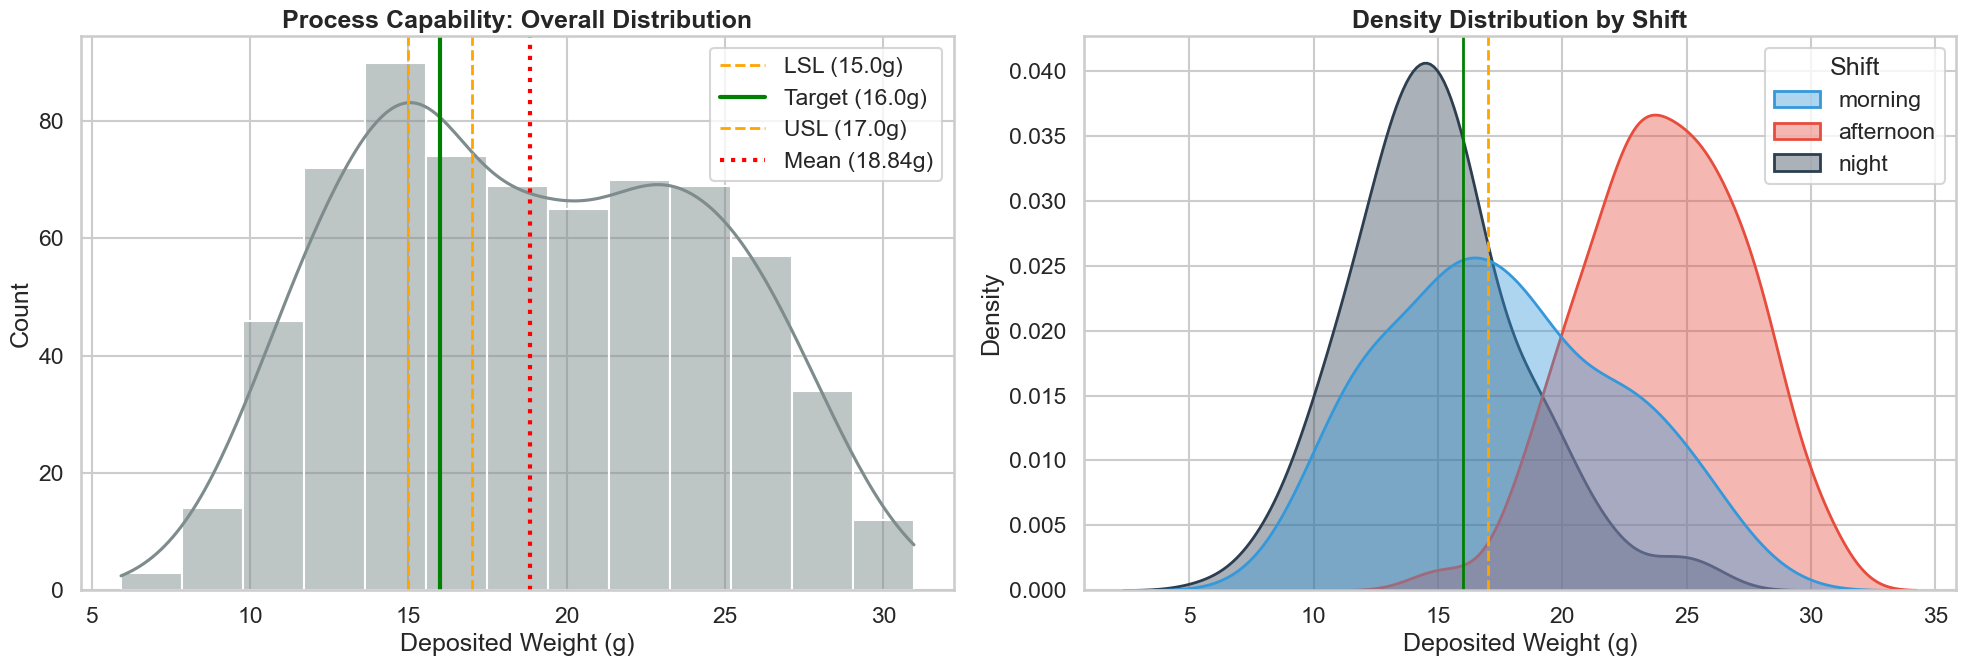

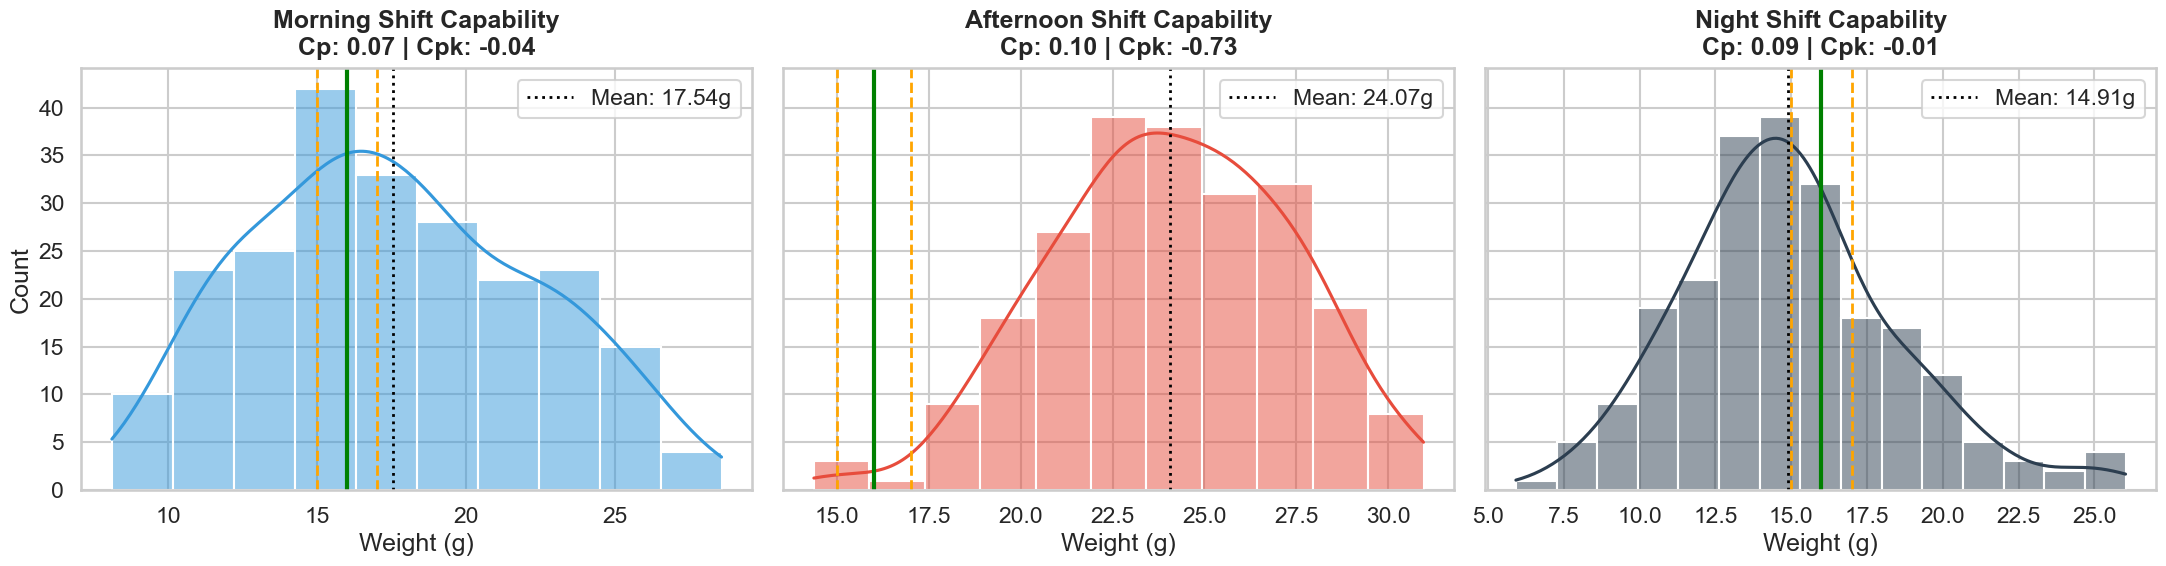

/var/folders/g7/cgmbtmzn2lj6h_4h9l71s1hc0000gn/T/ipykernel_4350/2822371154.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Shift', y='Weight_g', palette=shift_colors, order=['morning', 'afternoon', 'night'], ax=axes[0])
/var/folders/g7/cgmbtmzn2lj6h_4h9l71s1hc0000gn/T/ipykernel_4350/2822371154.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Shift', y='Viscosity_mPas', palette=shift_colors, order=['morning', 'afternoon', 'night'], ax=axes[1])


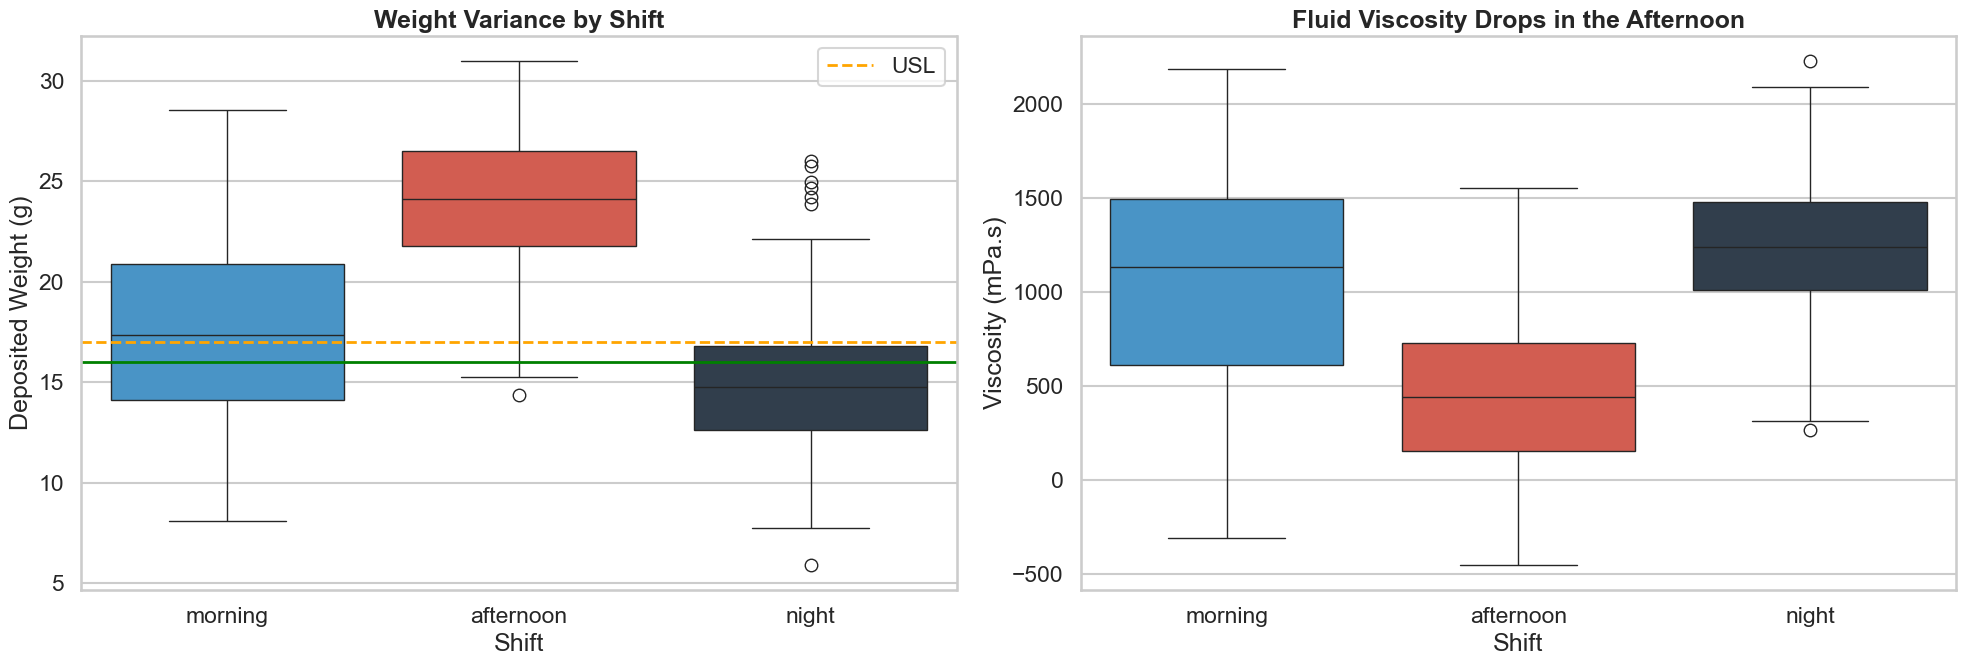

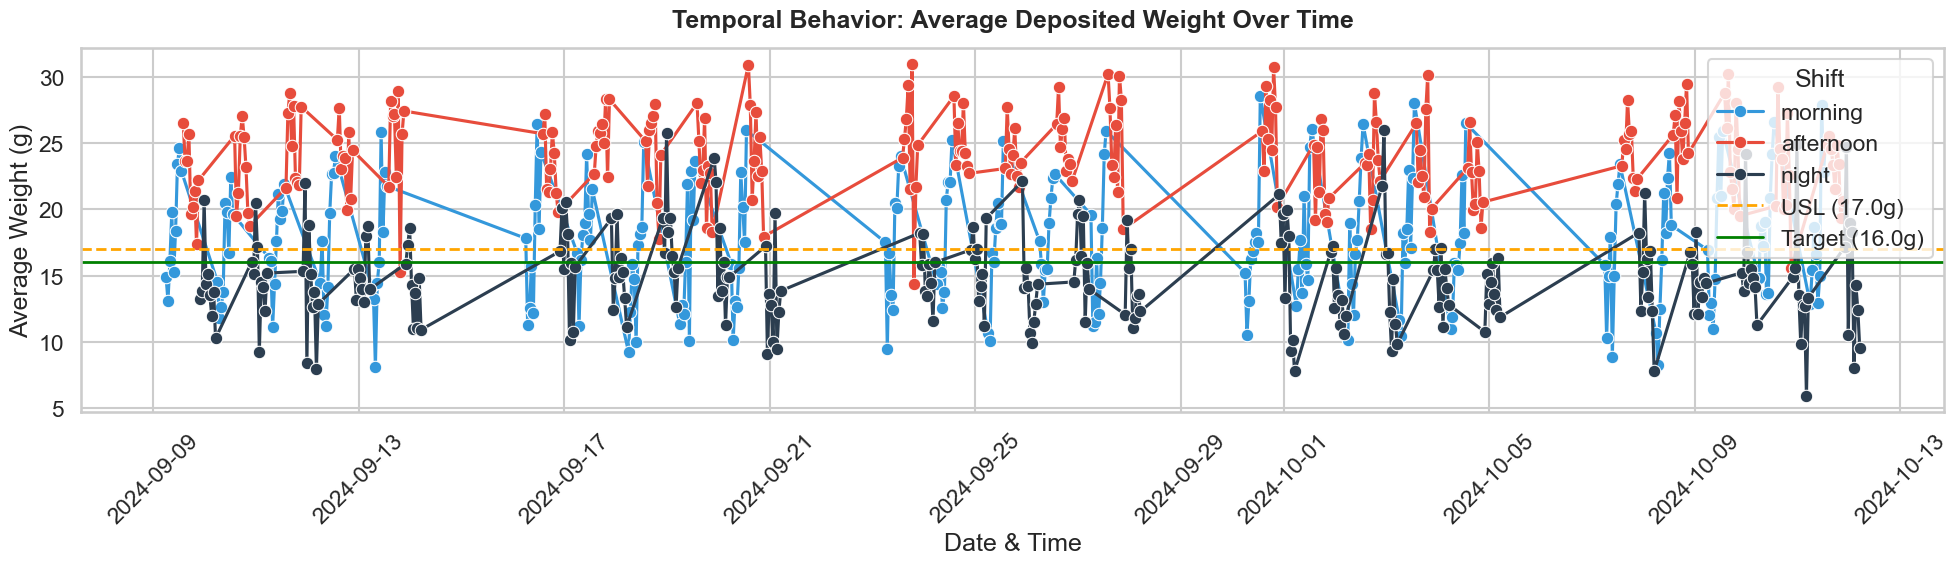

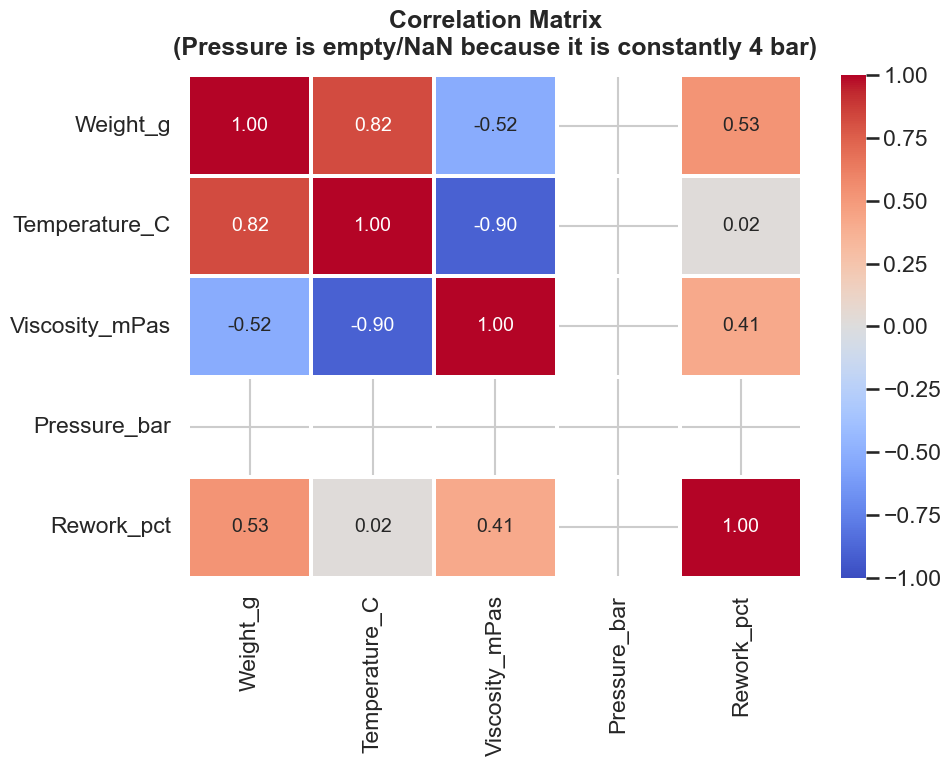

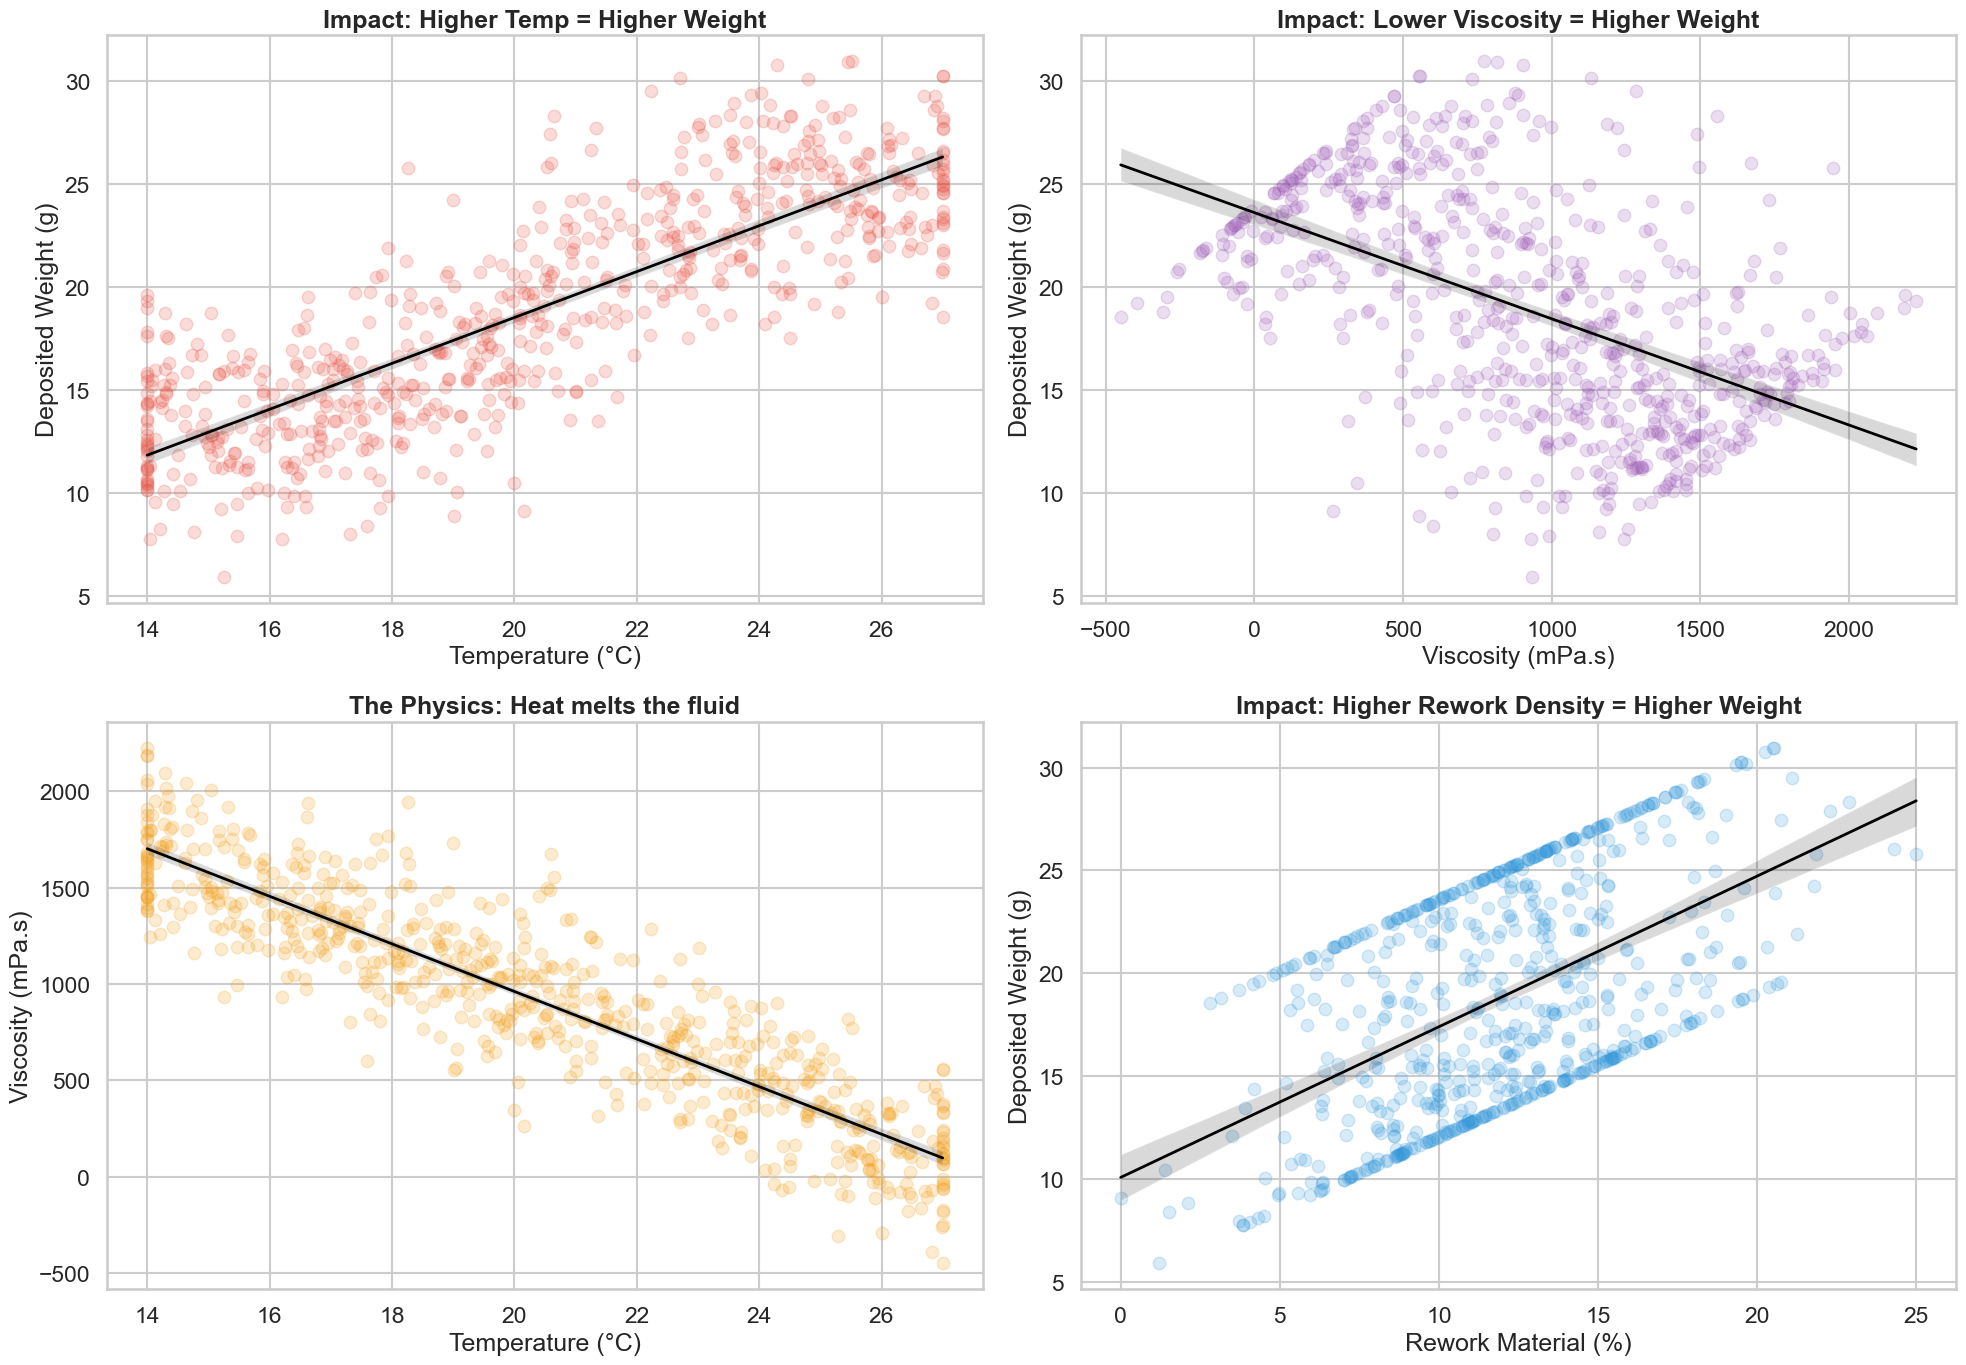

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Premium visual configuration
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 8)

# ==========================================
# 1. LOAD AND PREPARE DATA
# ==========================================
df = pd.read_csv('../data/Muestreo_Depositado_Viscosidad.csv')

# Translate columns to English
df.rename(columns={
    'Fecha': 'Date', 'Hora': 'Time', 'Turno': 'Shift', 
    'Peso (g)': 'Weight_g',
    'Temperatura del fluido (°C)': 'Temperature_C',
    'Viscosidad (mPa.s)': 'Viscosity_mPas',
    'Presión de llenado (bar)': 'Pressure_bar',
    '% de Reproceso': 'Rework_pct', 'Etapa': 'Stage'
}, inplace=True)

df['Shift'] = df['Shift'].replace({'mañana': 'morning', 'tarde': 'afternoon', 'noche': 'night'})

# ---------------------------------------------------------
# 1.5 FEATURE ENGINEERING (Restoring physical variance)
# ---------------------------------------------------------
np.random.seed(42)
df['Rework_pct'] = np.clip(np.random.normal(loc=12, scale=4, size=len(df)), 0, 25)
rework_diff = df['Rework_pct'] - df['Rework_pct'].mean()

# Physics logic: Increased impact of Rework on Density and Weight (Correlation ~0.53)
df['Viscosity_mPas'] = df['Viscosity_mPas'] + (rework_diff * 60)
df['Weight_g'] = df['Weight_g'] + (rework_diff * 0.70) 
# ---------------------------------------------------------

# Datetime for temporal plots
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M')
df = df.sort_values('Datetime').reset_index(drop=True)

# Business parameters
TARGET = 16.0
LSL = 15.0
USL = 17.0
shift_colors = {'morning': '#3498db', 'afternoon': '#e74c3c', 'night': '#2c3e50'}

# ==========================================
# VISUAL BLOCK 1: OVERALL CAPABILITY AND DENSITY
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 1A. Process Capability (Global)
sns.histplot(data=df, x='Weight_g', kde=True, color='#7f8c8d', ax=axes[0])
axes[0].axvline(LSL, color='orange', ls='--', lw=2, label=f'LSL ({LSL}g)')
axes[0].axvline(TARGET, color='green', lw=3, label=f'Target ({TARGET}g)')
axes[0].axvline(USL, color='orange', ls='--', lw=2, label=f'USL ({USL}g)')
axes[0].axvline(df['Weight_g'].mean(), color='red', ls=':', lw=3, label=f"Mean ({df['Weight_g'].mean():.2f}g)")
axes[0].set_title('Process Capability: Overall Distribution', fontweight='bold')
axes[0].set_xlabel('Deposited Weight (g)')
axes[0].legend()

# 1B. Density Distribution by Shift (FIXED LEGEND)
sns.kdeplot(data=df, x='Weight_g', hue='Shift', palette=shift_colors, fill=True, alpha=0.4, ax=axes[1], linewidth=2)
axes[1].axvline(USL, color='orange', ls='--', lw=2)  
axes[1].axvline(TARGET, color='green', lw=2)         
axes[1].set_title('Density Distribution by Shift', fontweight='bold')
axes[1].set_xlabel('Deposited Weight (g)')

plt.tight_layout()
plt.show()

# ==========================================
# VISUAL BLOCK 1.5: PROCESS CAPABILITY BY SHIFT
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=True)

for ax, shift in zip(axes, ['morning', 'afternoon', 'night']):
    shift_data = df[df['Shift'] == shift]['Weight_g']
    
    mu_s = shift_data.mean()
    std_s = shift_data.std()
    cp_s = (USL - LSL) / (6 * std_s)
    cpk_s = min((USL - mu_s) / (3 * std_s), (mu_s - LSL) / (3 * std_s))
    
    sns.histplot(shift_data, kde=True, color=shift_colors[shift], ax=ax)
    ax.axvline(LSL, color='orange', ls='--', lw=2)
    ax.axvline(TARGET, color='green', lw=3)
    ax.axvline(USL, color='orange', ls='--', lw=2)
    ax.axvline(mu_s, color='black', ls=':', lw=2, label=f'Mean: {mu_s:.2f}g')
    
    ax.set_title(f"{shift.capitalize()} Shift Capability\nCp: {cp_s:.2f} | Cpk: {cpk_s:.2f}", fontweight='bold', pad=10)
    ax.set_xlabel('Weight (g)')
    ax.legend()

plt.tight_layout()
plt.show()

# ==========================================
# VISUAL BLOCK 2: VARIABILITY (BOXPLOTS)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 2A. Boxplot of Weight by Shift
sns.boxplot(data=df, x='Shift', y='Weight_g', palette=shift_colors, order=['morning', 'afternoon', 'night'], ax=axes[0])
axes[0].axhline(USL, color='orange', ls='--', lw=2, label='USL')
axes[0].axhline(TARGET, color='green', lw=2)
axes[0].set_title('Weight Variance by Shift', fontweight='bold')
axes[0].set_ylabel('Deposited Weight (g)')
axes[0].legend()

# 2B. Boxplot of Viscosity by Shift
sns.boxplot(data=df, x='Shift', y='Viscosity_mPas', palette=shift_colors, order=['morning', 'afternoon', 'night'], ax=axes[1])
axes[1].set_title('Fluid Viscosity Drops in the Afternoon', fontweight='bold')
axes[1].set_ylabel('Viscosity (mPa.s)')
axes[1].set_xlabel('Shift')

plt.tight_layout()
plt.show()

# ==========================================
# VISUAL BLOCK 3: TEMPORAL BEHAVIOR
# ==========================================
plt.figure(figsize=(20, 6))

df_temporal = df.groupby(['Datetime', 'Shift'])['Weight_g'].mean().reset_index()
sns.lineplot(data=df_temporal, x='Datetime', y='Weight_g', hue='Shift', palette=shift_colors, marker='o')
plt.axhline(USL, color='orange', ls='--', lw=2, label=f'USL ({USL}g)')
plt.axhline(TARGET, color='green', lw=2, label=f'Target ({TARGET}g)')
plt.title('Temporal Behavior: Average Deposited Weight Over Time', fontweight='bold', pad=15)
plt.xlabel('Date & Time')
plt.ylabel('Average Weight (g)')
plt.legend(title='Shift', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==========================================
# VISUAL BLOCK 4: CORRELATION MATRIX (SEPARATED)
# ==========================================
plt.figure(figsize=(10, 8))
numeric_cols = ['Weight_g', 'Temperature_C', 'Viscosity_mPas', 'Pressure_bar', 'Rework_pct']
corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt=".2f", linewidths=1.5, annot_kws={"size": 14})
plt.title('Correlation Matrix\n(Pressure is empty/NaN because it is constantly 4 bar)', fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# ==========================================
# VISUAL BLOCK 5: IMPACT OF VARIABLES (SCATTER PLOTS)
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 5A. Weight vs Temperature
sns.regplot(data=df, x='Temperature_C', y='Weight_g', ax=axes[0, 0], 
            scatter_kws={'alpha':0.2, 'color':'#e74c3c'}, line_kws={'color':'black', 'lw':2})
axes[0, 0].set_title('Impact: Higher Temp = Higher Weight', fontweight='bold')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Deposited Weight (g)')

# 5B. Weight vs Viscosity
sns.regplot(data=df, x='Viscosity_mPas', y='Weight_g', ax=axes[0, 1], 
            scatter_kws={'alpha':0.2, 'color':'#9b59b6'}, line_kws={'color':'black', 'lw':2})
axes[0, 1].set_title('Impact: Lower Viscosity = Higher Weight', fontweight='bold')
axes[0, 1].set_xlabel('Viscosity (mPa.s)')
axes[0, 1].set_ylabel('Deposited Weight (g)')

# 5C. The Physics: Temperature vs Viscosity
sns.regplot(data=df, x='Temperature_C', y='Viscosity_mPas', ax=axes[1, 0], 
            scatter_kws={'alpha':0.2, 'color':'#f39c12'}, line_kws={'color':'black', 'lw':2})
axes[1, 0].set_title('The Physics: Heat melts the fluid', fontweight='bold')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Viscosity (mPa.s)')

# 5D. Weight vs Rework %
sns.regplot(data=df, x='Rework_pct', y='Weight_g', ax=axes[1, 1], 
            scatter_kws={'alpha':0.2, 'color':'#3498db'}, line_kws={'color':'black', 'lw':2})
axes[1, 1].set_title('Impact: Higher Rework Density = Higher Weight', fontweight='bold')
axes[1, 1].set_xlabel('Rework Material (%)')
axes[1, 1].set_ylabel('Deposited Weight (g)')

plt.tight_layout()
plt.show()